# Kalman filter

In [1]:
import numpy as np
# Convenience shortcuts, needed because when numpy matrix multiplications result in 1x1 matrix
# then it is output as scalar, which further matrix multiplications refuse to work with. This makes no sense.
# It is impossible to write a clean code that would work with matrices regardless of their shape!

def ext_kf(u,P,F,Q=0,d=None,H=None,R=None):
  """
  One step of the extended Kalman filter. 
  If there is no data, only advance in time.
  :param u:   the state vector, shape n
  :param P:   the state covariance, shape (n,n)
  :param Q:   the process model noise covariance, shape (n,n)
  :param F:   the model function, maps vector u to vector F(u) and Jacobian J(u)
  :param d:   data vector, shape (m)
  :param H:   observation matrix, shape (m,n)
  :param R:   data error covariance, shape (n,n)
  :return ua: the analysis state vector, shape (n)
  :return Pa: the analysis covariance matrix, shape (n,n)
  """
  def d2(a):
    return np.atleast_2d(a) # convert to at least 2d array

  def d1(a):
    return np.atleast_1d(a) # convert to at least 1d array

  # forecast
  uf, J  = F(u)          # advance the model state in time and get the Jacobian
  uf = d1(uf)            # if scalar, make state a 1D array
  P = d2(P)              # if scalar, make Jacobian as 2D array
  Pf  = d2(J.T @ P) @ J + Q  # advance the state covariance Pf = J' * P * J + Q
  # analysis
  if d is None or not d.size :  # no data, no analysis
    return uf, Pf
  # K = P H' * inverse(H * P * H' + R) = (inverse(H * P * H' + R)*(H P))'
  H = d2(H)
  HP  = d2(H @ P)            # precompute a part used twice  
  K   = d2(np.linalg.solve( d2(HP @ H.T) + R, HP)).T  # Kalman gain
  # print('H',H)
  # print('K',K)
  res = d1(H @ d1(uf) - d)          # res = H*uf - d
  ua = uf - K @ res # analysis mean uf - K*res
  Pa = Pf - K @ d2(H @ P)        # analysis covariance
  return ua, d2(Pa)


##  A basic exponential decay model

The model is defined by solving the differential equation on interval $\left[
t_{0},t_{1}\right]  $,
$$
\frac{dm}{dt}=\frac{E-m(t)}{T},\quad m(t_{0})=m_{0}.
$$
where the initial fuel moisture content $m_{0}=m\left(  t_{0}\right)  $ is the
input, and $m_{1}=m(t_{1})$ is the output. The parameters of the model are
fuel moisture equilibrium $E$, assumed constant over the interval $\left[
t_{0},t_{1}\right]  $, the characteristic decay time $T$, and the length of
the interval, $t_{1}-t_{0}$. 

We can build the general model by calling this simple model with different
equilibria and time constants (drying, wetting, rain).

Since $E$ is constant in time, the solution can be found
analytically,
$$
m\left(  t\right)  =E+\left(  m_{0}-E\right)  e^{-t/T}%
$$
For convenience, we use $T_{1}=1/T$ instead of $T$, and the model becomes
$$
m_{1}=E+\left(  m_{0}-E\right)  e^{-\left(  t_{1}-t_{0}\right)  T_{1}}%
$$
In the extended Kalman filter, we will need the partial derivatives of $m_{1}$
with respect to the input and the parameters. Compute
$$
\frac{dm_{1}}{d_{m0}}=e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dE}=1-e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dT_{1}}=-\left(  m_{0}-E\right)  \left(  t_{1}-t_{0}\right)
e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
At the moment, we need only ${dm_{1}}/{dm_{0}}$ but we put in the code all partials for possible use infuture.


In [2]:
import numpy as np
def model_decay(m0,E,partials=0,T1=0.1,tlen=1):
  exp_t = np.exp(-tlen*T1)                  # compute this subexpression only once
  m1 = E + (m0 - E)*exp_t                   # the solution at end
  if partials==0:
    return m1
  dm1_dm0 = exp_t
  if partials==1:
    return m1, np.array([dm1_dm0])          # return value and Jacobian
  dm1_dE = 1 - exp_t                        # partial derivative dm1 / dE
  dm1_dT1 = -(m0 - E)*tlen*exp_t            # partial derivative dm1 / dT1
  return m1, dm1_dm0, dm1_dE, dm1_dT1       # return value and all partial derivatives wrt m1 and parameters
  

## Kalman filter demonstration

### Create synthetic data

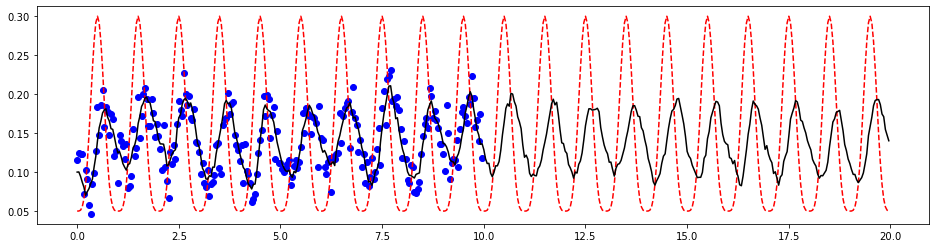

In [3]:
import numpy as np, random
days = 10       
hours = days*24
day = np.array(range(2*hours))/24.

# artificial equilibrium data
E = np.power(np.sin(np.pi*day),4) # diurnal curve
E = 0.05+0.25*E
E # scale 
# FMC free run
m_f = np.zeros(2*hours)
m_f[0] = 0.1         # initial FMC
for t in range(2*hours-1):
  m_f[t+1] = max(0.,model_decay(m_f[t],E[t])  + random.gauss(0,0.005) )
data = m_f + np.random.normal(loc=0,scale=0.02,size=2*hours)    

%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(day[0:2*hours],E[0:2*hours],linestyle='--',c='r',label='Equilibrium')
plt.plot(day[0:2*hours],m_f[0:2*hours],linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
 

### Run Kalman filter

We have used the same code for model and for the truth. Now what if the model is wrong - different from nature? That is always so in reality. Suppose,for example, that the equilibrium $E$ in the model and in the truth does not agree, the model thinks that $E$ is by $\Delta E$ too high:

In [4]:
import numpy as np
import matplotlib.pyplot as plt 

def kf_example(DeltaE):
  m = np.zeros(2*hours)
  m[0]=0.1             # background state  
  P = np.zeros(2*hours)
  P[0] = 0.03 # background state variance
  Q = np.array([0.02]) # process noise variance
  H = np.array([1.])   # all observed
  R = np.array([0.02]) # data variance

  for t in range(hours):
    # use lambda construction to pass additional arguments to the model 
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
  for t in range(hours,2*hours - 1):
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
  %matplotlib inline
  plt.figure() # new figure
  plt.plot(day,P,linestyle='-',c='b',label='Estimated state variance P')
    
  %matplotlib inline
  plt.figure(figsize=(16,4))
  plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
  plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
  plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
  plt.plot(day,m,linestyle='-',c='r',label='filtered')

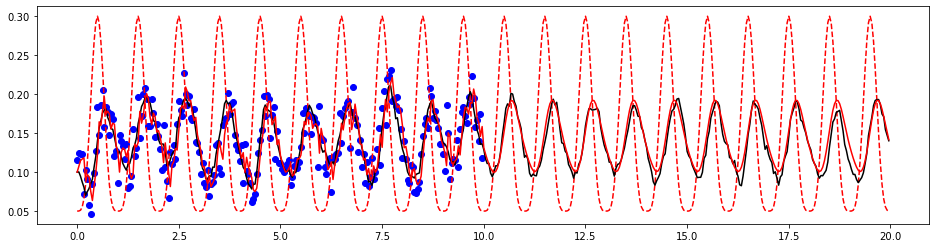

In [5]:
DeltaE = 0.0          # bias
kf_example(DeltaE)

We have recovered the fuel moisture from data with random noise - we **filtered** the noise out. 

Now suppose that the model and the truth are not the same. That is always the case in reality. 
Consider a simple case when the model thinks that the equilibrium $E$ is too high.

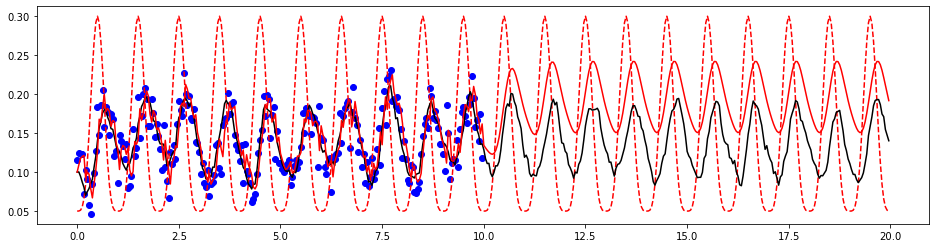

In [6]:
DeltaE = 0.05
kf_example(DeltaE)  

We have found a good estimate of the state $m$. Also, the estimated state variance $P$ converges with time - we have *learned* the variance that balances the noise. But for forecasting fuel moisture, we need to continue the fuel moisture model into the future, and we can't have any measurements from future. We only have the equilibrium from weather forecast.

First, make the API available

In [7]:
!pip install MesoPy
from MesoPy import Meso

 Get all stations with fuel moisture data in the box within one hour: 

In [8]:
# Take the first station in the boulding box that has data between time_start and time_s2.
# Then retrieve data for that station between time_start and time_end
time_start = "201806010800"  # June 1 2018 08:00 in format yyyymmddHHMM 
time_s2   = "201806010900"  # June 1 2018 09:00 in format yyyymmddHHMM 
time_end   = "201806200900"  # Nov 1 2018 09:00 in format yyyymmddHHMM 
bounding_box = "-115, 38, -110, 40"  # min longtitude, latitude
meso_token="b40cb52cbdef43ef81329b84e8fd874f"       # you should get your own if you do more of this
m = Meso(meso_token)                                     # create a Meso object
meso_obss = m.timeseries(time_start, time_s2, bbox=bounding_box, showemptystations = '0', vars='fuel_moisture')   # ask the object for data

Print the result:

In [9]:
import json
#print(json.dumps(meso_obss, indent=4))


Pick one station 

In [10]:
station=meso_obss['STATION'][0]
#print(json.dumps(station, indent=4))
lon,lat = (float(station['LONGITUDE']),float(station['LATITUDE']))
print(station['NAME'],'station',station['STID'],'at',lon,lat)
e = 0.01
bb = '%s, %s, %s, %s' % (lon - e, lat - e, lon + e, lat + e)
print('bounding box',bb)
meso_ts = m.timeseries(time_start, time_end, bbox=bb, showemptystations = '0', vars='fuel_moisture')   # ask the object for data
 

BLACK CEDAR station BKCU1 at -112.238864 38.979242
bounding box -112.24886400000001, 38.969242, -112.228864, 38.989242


2018-06-01 08:27:00+00:00 4.9
2018-06-01 09:27:00+00:00 5.0
2018-06-01 10:27:00+00:00 5.2
2018-06-01 11:27:00+00:00 5.2
2018-06-01 12:27:00+00:00 5.3
2018-06-01 13:27:00+00:00 5.6
2018-06-01 14:27:00+00:00 6.3
2018-06-01 15:27:00+00:00 6.8
2018-06-01 16:27:00+00:00 6.9
2018-06-01 17:27:00+00:00 7.0
2018-06-01 18:27:00+00:00 7.2
2018-06-01 19:27:00+00:00 6.6
2018-06-01 20:27:00+00:00 6.2
2018-06-01 21:27:00+00:00 5.7
2018-06-01 22:27:00+00:00 5.5
2018-06-01 23:27:00+00:00 5.3
2018-06-02 00:27:00+00:00 5.2
2018-06-02 01:27:00+00:00 5.1
2018-06-02 02:27:00+00:00 5.1
2018-06-02 03:27:00+00:00 5.1
2018-06-02 04:27:00+00:00 5.2
2018-06-02 05:27:00+00:00 5.3
2018-06-02 06:27:00+00:00 5.7
2018-06-02 07:27:00+00:00 5.9
2018-06-02 08:27:00+00:00 6.1
2018-06-02 09:27:00+00:00 6.4
2018-06-02 10:27:00+00:00 6.5
2018-06-02 11:27:00+00:00 6.6
2018-06-02 12:27:00+00:00 7.0
2018-06-02 13:27:00+00:00 7.2
2018-06-02 14:27:00+00:00 7.9
2018-06-02 15:27:00+00:00 7.7
2018-06-02 16:27:00+00:00 7.5
2018-06-02

Text(0.5, 1.0, 'BKCU1 10 h fuel moisture data')

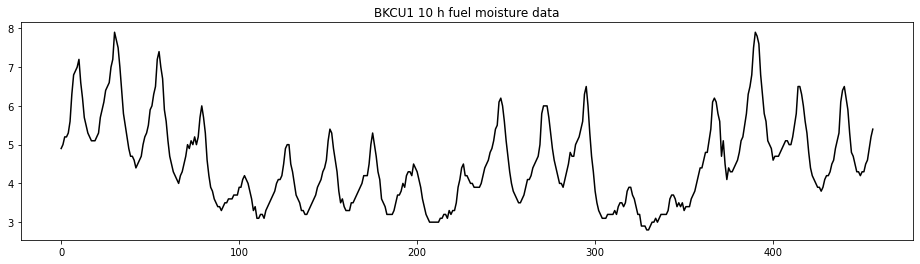

In [11]:
# process the data retrieved for this statin
# print(json.dumps(meso_ts['STATION'][0], indent=4))
from datetime import datetime, timedelta, time
import pytz
time_str  = meso_ts['STATION'][0]['OBSERVATIONS']['date_time']
obs_time = [datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=pytz.UTC) for t in time_str]
obs_data = np.array(meso_ts['STATION'][0]['OBSERVATIONS']["fuel_moisture_set_1"])
# display the data retrieved
for o_time,o_data in zip (obs_time,obs_data):
    print(o_time,o_data)
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(obs_data,linestyle='-',c='k',label='10-h fuel data')
plt.title(station['STID'] + ' 10 h fuel moisture data' )


In [12]:
# retrieve RTMA data for this time period and compute equilibrium fuel moisture


In [13]:
import numpy as np, os
if not [int(i) for i in np.__version__.split('.')] >= [1,20,1]: # check numpy version
  print('Upgrading numpy and stopping RUNTIME! When the notebook completes, please run again.')
  ! pip install --upgrade numpy    # suggested by Efosa, see also https://github.com/jswhit/pygrib/issues/192
  os.kill(os.getpid(), 9)          # kill the runtime, need to run again from the beginning

Installing dependences:

In [14]:
! pip install pygrib   
! wget --no-clobber https://raw.githubusercontent.com/openwfm/wrfxpy/master/src/ingest/grib_file.py
from grib_file import GribFile     # Martin's utility layer on top of  pygrib,from wrfxpy
import numpy as np, os # imported before, just in case


File ‘grib_file.py’ already there; not retrieving.



Create a function to transfer RTMA file in GRIP2 format from the stash. The function returns zero if the file transfer succeeded. If the file is not available, it returns a nonzero value. Note: if needed, maybe in future add more sophisticated checks, check the return code of wget and if the file size is correct.

In [15]:
import subprocess,os
def load_rtma(path,file,reload=0):
  url='http://math.ucdenver.edu/~jmandel/rtma/' + path 
  if os.path.exists(file):
    if reload:
      print(file + ' already exists, removing')
      os.remove(file)
    else:
      print(file + ' already exists, exiting')
      # add checking size here
      return 0
  try:
    ret = subprocess.check_output(['wget','--no-clobber','--output-document='+ file, url,],stderr=subprocess.STDOUT).decode() # execute command from python strings
    if os.path.exists(file):
      print('loaded ' + url + ' as ' + file)
      return 0
    else: 
      print('file transfer completed, but the file is missing? ' + url)  
      return 1
  except:
    print('file transfer failed: ' + url)
    return 2


Get the files we need

In [ ]:
import pandas as pd
import intergrid
def rtma_grib(t,var):
    tpath = '%4i%02i%02i/%02i' % (t.year, t.month, t.day, t.hour)
    tstr  = '%4i%02i%02i%02i_' % (t.year, t.month, t.day, t.hour)
    gribfile = tstr + var + '.grib'
    if load_rtma(tpath + '/' + var + '.grib',gribfile):
        print('cannot load file')
    gf=GribFile(gribfile)
    v = np.array(gf[1].values())
    print('loaded array shape ',v.shape)
    return gf[1]   # grib message
for t in pd.date_range(start=obs_time[0].replace(minute=0),end=obs_time[-1],freq='1H'):
    print(t)
    gf = rtma_grib(t,'temp')   # temperature
    gf = rtma_grib(t,'td')     # dew point
    gf = rtma_grib(t,'precipa')# rain    


2018-06-01 08:00:00+00:00
2018060108_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060108_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060108_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-01 09:00:00+00:00
2018060109_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060109_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060109_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-01 10:00:00+00:00
2018060110_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060110_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060110_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-01 11:00:00+00:00
2018060111_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060111_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060111_precipa.grib already exist

loaded array shape  (1377, 2145)
2018060216_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-02 17:00:00+00:00
2018060217_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060217_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060217_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-02 18:00:00+00:00
2018060218_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060218_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060218_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-02 19:00:00+00:00
2018060219_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060219_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060219_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-02 20:00:00+00:00
2018060220_temp.grib already exists, exiting
loaded array shape  (1377, 2145)

loaded array shape  (1377, 2145)
2018-06-04 01:00:00+00:00
2018060401_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060401_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060401_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-04 02:00:00+00:00
2018060402_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060402_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060402_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-04 03:00:00+00:00
2018060403_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060403_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060403_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-04 04:00:00+00:00
2018060404_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060404_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018

loaded array shape  (1377, 2145)
2018060509_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-05 10:00:00+00:00
2018060510_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060510_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060510_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-05 11:00:00+00:00
2018060511_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060511_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060511_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-05 12:00:00+00:00
2018060512_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060512_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060512_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-05 13:00:00+00:00
2018060513_temp.grib already exists, exiting
loaded array shape  (1377, 2145)

2018-06-06 18:00:00+00:00
2018060618_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060618_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060618_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-06 19:00:00+00:00
2018060619_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060619_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060619_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-06 20:00:00+00:00
2018060620_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060620_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060620_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-06 21:00:00+00:00
2018060621_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060621_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060621_precipa.grib already exist

loaded array shape  (1377, 2145)
2018-06-08 03:00:00+00:00
2018060803_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060803_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060803_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-08 04:00:00+00:00
2018060804_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060804_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060804_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-08 05:00:00+00:00
2018060805_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060805_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060805_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-08 06:00:00+00:00
2018060806_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060806_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018

loaded array shape  (1377, 2145)
2018060911_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-09 12:00:00+00:00
2018060912_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060912_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060912_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-09 13:00:00+00:00
2018060913_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060913_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060913_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-09 14:00:00+00:00
2018060914_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060914_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018060914_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-09 15:00:00+00:00
2018060915_temp.grib already exists, exiting
loaded array shape  (1377, 2145)

loaded array shape  (1377, 2145)
2018061019_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061019_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-10 20:00:00+00:00
2018061020_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061020_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061020_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-10 21:00:00+00:00
2018061021_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061021_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061021_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-10 22:00:00+00:00
2018061022_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061022_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061022_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-10 23:00:00+00:00
2

loaded array shape  (1377, 2145)
2018061203_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061203_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-12 04:00:00+00:00
2018061204_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061204_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061204_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-12 05:00:00+00:00
2018061205_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061205_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061205_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-12 06:00:00+00:00
2018061206_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061206_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061206_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-12 07:00:00+00:00
2

2018061311_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-13 12:00:00+00:00
2018061312_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061312_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061312_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-13 13:00:00+00:00
2018061313_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061313_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061313_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-13 14:00:00+00:00
2018061314_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061314_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061314_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-13 15:00:00+00:00
2018061315_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061315_td.grib already exist

loaded array shape  (1377, 2145)
2018-06-14 21:00:00+00:00
2018061421_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061421_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061421_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-14 22:00:00+00:00
2018061422_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061422_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061422_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-14 23:00:00+00:00
2018061423_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061423_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061423_precipa.grib already exists, exiting
loaded array shape  (1377, 2145)
2018-06-15 00:00:00+00:00
2018061500_temp.grib already exists, exiting
loaded array shape  (1377, 2145)
2018061500_td.grib already exists, exiting
loaded array shape  (1377, 2145)
2018

In [ ]:
import pandas as pd

for i in pd.time_range
year, month, day, hour, variable  = (2018, 5, 18, 00, 'temp')  # year, month, day, hour, variable
file = variable + '.grib'
path = '%4i%02i%02i/%02i/%s' % (year, month, day, hour, file)

ret=load_rtma(path,file)   # load the file; ret is the return value that can be tested in application



Trying to read the file and a basic sanity check if the values make sense:

In [ ]:
gf = GribFile(file)[1]        # grib file consists of "messages" (basically, variables), rtma files have only one
lats, lons = gf.latlons()     # grid of geo coodinates (computed), should be the same for all rtma files here
lats = np.array(lats)         # tuple to numpy array
lons = np.array(lons)         # tuple to numpy array
temp = np.array(gf.values())  # the actual variable values (here, T at 2m in K)

print('min lats %s max %s' % (np.amin(lats),np.amax(lats)))
print('shape',lats.shape)
print('min lons %s max %s' % (np.amin(lons),np.amax(lons)))
print('shape',lons.shape)
print('min temp %s max %s' % (np.amin(temp),np.amax(temp)))
print('shape',temp.shape)


One special grib file with the terrain height is stored at the root of the stash. This file is a part of the RTMA dataset but no need to download and store every hour, the data should never change. Trying to read it and doing a sanity check. Also,checking if the grid coordinages in this file are the same as before.


In [ ]:
hf='ds.terrainh.bin'   # terrain height, same in rtma at all times
load_rtma(hf,hf)
gf = GribFile(hf)[1] 
hgt = np.array(gf.values()) # height in m
print('min height %s max %s' % (np.amin(hgt),np.amax(hgt)))
print('shape',hgt.shape)
hlats, hlons = gf.latlons()     # grid of geo coodinates (computed), should be the same for all rtma files here
hlats = np.array(hlats)         # tuple to numpy array
hlons = np.array(hlons) 
print('difference in lats %s lons %s' % (np.amax(np.absolute(lats-hlats)), np.amax(np.absolute(lons-hlons))))


## Model with augmented state
In reality, the equilibrium moisture $E$ computed from atmospheric conditions
generally does not agree with the data. We want to add a correction $\Delta
E$ to $E$ constant in time, and identify the new parameter $\Delta E$ from data. 
Because the Kalman filter identifies state, add the parameter to the state.
Define augmented state $u=\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  .$ Since $\Delta E$ is constant in time, it satisfies the
differential equation $\frac{d\Delta E}{dt}=0.$ So, we want to estimate the
state $u$ governed by the
$$
\frac{d}{dt}\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
\frac{E+\Delta E-m(t)}{T}\\
0
\end{array}
\right]  ,
$$
which we write as $\frac{du}{dt}=F(u),$ where
$$
F(u)=\left[
\begin{array}
[c]{c}
F_{1}\left(  u\right)  \\
F_{2}\left(  u\right)
\end{array}
\right]  =F\left(  \left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  \right)  =\left[
\begin{array}
[c]{c}
\left(  E+\Delta E-m(t)\right)  T_{1}\\
0
\end{array}
\right]  ,\quad T_{1}=\frac{1}{T}.
$$
The Jacobian of $F$ is
$$
\left[
\begin{array}
[c]{cc}
\frac{\partial F_{1}}{\partial u_{1}} & \frac{\partial F_{1}}{\partial u_{2}
}\\
\frac{\partial F_{2}}{\partial u_{1}} & \frac{\partial F_{2}}{\partial u_{2}}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
\frac{\partial\Delta E}{\partial m_{0}} & \frac{\partial\Delta E}
{\partial\Delta E}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
0 & 1
\end{array}
\right]
$$
Here is a function that implements the augmented model $F$. The input is
$u_{0}$. The output is $u_{1}$ and the Jacobian $du_{1}/du_{0}$.

In [ ]:
def model_augmented(u0,E,T1,tlen=1):
  # state u is the vector [m,dE] with dE correction to equilibrium
  m0 = u0[0]  # decompose u0
  dE = u0[1]
  m1, dm1_dm0, dm1_dE, dm1_dT1  = model_decay(m0,E + dE,T1,tlen=tlen)
  u1 = np.array([m1,dE])
  J = np.array([dm1_dm0, dm1_dE],
               [0.     ,     1.])
  return m0, J

In [ ]:
u = np.zeros((2,2*hours)
u[:,0]=[0.1,0.1]             # background state  
P = np.zeros(2,2,2*hours)
P[:,:,0] = np.array([[0.03, 0.],
                  [0.,    0.03]]) # background state covariance
Q = np.array([[0.03, 0.],
            [0,    0.03]]) # process noise covariance
H = np.array([[1., 0.],
             [0.,  .0]])   # first component observed
R = np.array([0.02]) # data variance

DeltaE = 0.05          # bias
for t in range(hours):
  # use lambda construction to pass additional arguments to the model 
  u[:,t+1],P[:,:,t+1] = ext_kf(m[:,t],d2(P[:,:,t]),lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
for t in range(hours,2*hours - 1):
  u[:,t+1],P[:,:,t+1] = ext_kf(m[t],d2(P[t]),lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
    
%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
plt.plot(day,m,linestyle='-',c='r',label='filtered')




In [ ]:
DeltaE

In [ ]:
d=np.array([])
if d:
  print('yes')

In [ ]:
for d in range(24):
  print(d)

# With real data

In [ ]:
! pip install intergrid
from intergrid.intergrid import Intergrid  # docs https://pypi.org/project/intergrid/
from datetime import date
import pandas as pd
start_date = date(2018,5,19)
end_date = date(2020,6,1)
for d in pd.date_range(start_date,end_date,freq="1h"):
    path = d.strftime("%Y%m%d/%H")
    print(path)

#Experiments

In [ ]:
import numpy as np
a = np.array([1.])
b = np.array([2.])
c  = a @ b
print('a',a)
print('b',b)
print('c=a@b',c)

# Testers

In [ ]:
# a basic ext_kf test
import numpy as np
u = [1,
     2]
P = [[2 , -1],
    [-1 , 2]]
A = [ [1 ,2],
      [3 ,4]]
u = np.array(u)      
Q = np.array([[1,0],[0,1]])
A = np.array(A)
def fun(u):
  return A @ u, A
F = lambda u: fun(u)
H = [[1, 0],
     [0, 1]]
d = [2,
    3]
R = [[2, 0],
    [0, 2]]
H = np.array(H)      
d = np.array(d)
R = np.array(R)
ua,Pa = ext_kf(u,P,F,Q)
print('ua=',ua)
print('Pa=',Pa)
ua,Pa = ext_kf(u,P,F,Q,d,H,R)
print('ua=',ua)
print('Pa=',Pa)
